# EMA mean reversion strategy - Long & Short direction 
- enter positions to the opposite direction when price candle closes below or above the EMA lines


## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters

In [26]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.lending import LendingProtocolType
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency

# Tell what trade execution engine version this strategy needs to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE_ENGINE_VERSION = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# How our trades are routed.
TRADE_ROUTING = TradeRouting.uniswap_v3_usdc

# How often the strategy performs the decide_trades cycle.
# We do it for every 4h.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_4h

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Candle time frame: Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h4

# Which trading pair we are backtesting on
TRADING_PAIR = (ChainId.polygon, "uniswap-v3", "WETH", "USDC", 0.0005)

# Which lending reserves we are using for supplying/borrowing assets
LENDING_RESERVES = [
    (ChainId.polygon, LendingProtocolType.aave_v3, "WETH"),
    (ChainId.polygon, LendingProtocolType.aave_v3, "USDC"),
]

# How much % of the available trading capital to put on a single trade
POSITION_SIZE = 0.75

# Start with this amount of USD
INITIAL_DEPOSIT = 50_000

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.h1


# How many candles we load in the decide_trades() function for calculating indicators
LOOKBACK_WINDOW = 20

# Exponential Moving Average (EMA)
# How many candles to smooth out for EMA line
EMA_CANDLE_COUNT = 2  


# How many candles we use to calculate the Relative Strength Index
RSI_LENGTH = 5

# RSI threshold for opening a long position
RSI_THRESHOLD = 25 

# RSI threshold for opening a short position
RSI_THRESHOLD_SHORT = 75 

# Backtest range
START_AT = datetime.datetime(2022, 10, 1)

# Backtest range
END_AT = datetime.datetime(2023, 10, 1)


### FOR LONGS ###

# Stop Loss relative to the mid price during the time when the position is opened
# If the price drops below this level, trigger a stop loss sell
STOP_LOSS_PCT = 0.985

# Take profit percentage for longs
TAKE_PROFIT_PCT = 1.15

# What is the trailing stop loss level, this trails the most recent candle close price
TRAILING_STOP_LOSS_PCT = 0.99

# Activate trailing stop loss when this level is reached
# TRAILING_STOP_LOSS_ACTIVATION_LEVEL=1.01 (In this strategy we don't use a fixed activation level but EMA line crossing is used instead.)


### FOR SHORTING ###

TAKE_PROFIT_SHORT_PCT = 1.15

STOP_LOSS_SHORT_PCT = 0.985

# What is the Trailing Stop Loss level
TRAILING_STOP_LOSS_SHORT_PCT = 0.99

# Activate Trailing Stop Loss when this level is reached
#TRAILING_STOP_LOSS_SHORT_ACTIVATION_LEVEL = 0.99 (In this strategy we don't use a fixed activation level but EMA line crossing is used instead.)

# Leverage ratio for shorting positions. This is due to the mechanism that the shorting protocol needs as we are not able to borrow assets with 1:1 collateral. 
LEVERAGE = 1


## Strategy logic and trade decisions

- `decide_trades` function decide what trades to take.
- In this example, we calculate exponential moving averages
(EMAs), RSI and make decisions based on these.



In [27]:
from typing import List, Dict

from pandas_ta import bbands
from pandas_ta.overlap import ema
from pandas_ta.momentum import rsi

from tradingstrategy.universe import Universe
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse

from tradeexecutor.state.visualisation import PlotKind, PlotShape
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager


def decide_trades(
        timestamp: pd.Timestamp,
        strategy_universe: TradingStrategyUniverse,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
  
    universe = strategy_universe.universe

    # We have only a single trading pair for this strategy.
    pair = universe.pairs.get_single()

    # How much cash we have in a hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=LOOKBACK_WINDOW)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]

    # Calculate exponential moving from candle close prices
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/overlap/help/pandas_ta.overlap.ema.html#ema
    ema_series = ema(close_prices, length=EMA_CANDLE_COUNT)
    
    # Calculate RSI from candle close prices
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/momentum/help/pandas_ta.momentum.rsi.html#rsi
    current_rsi = rsi(close_prices, length=RSI_LENGTH)[-1]

    trades = []
 
    ema_latest = ema_series.iloc[-1]      # Let's take the latest EMA value from the series
    price_latest = close_prices.iloc[-1]  # Let's take the latest close price value from the series
    
    if ema_series is None:
        # Check if we cannot calculate EMA, because there's not enough data in backtesting buffer yet.
        return trades
    

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, strategy_universe, state, pricing_model)

    

    
    ### LONGING ###
    
    stoploss_price_long = None    # We use this to track Stop Loss price for Long positions and draw it to the price chart
    
    if not position_manager.is_any_long_position_open():
        if position_manager.is_any_short_position_open():
            return trades

        if price_latest < ema_latest and current_rsi < RSI_THRESHOLD and close_prices.iloc[-2] > ema_series.iloc[-2]:
            amount = cash * POSITION_SIZE
            new_trades = position_manager.open_1x_long(pair, amount, stop_loss_pct=STOP_LOSS_PCT, take_profit_pct=TAKE_PROFIT_PCT)
            trades.extend(new_trades)
            stoploss_price_long = position_manager.get_current_long_position().stop_loss
            
    else:
        current_position = position_manager.get_current_long_position()
        # LONGING: We activate trailing stop loss when the price closes above the EMA line.

        if price_latest >= ema_latest:
            # adjust trailing stop loss level for the open long position
            # Stop loss is the only way we sell in this set up, unless TAKE_PROFIT_PCT level has been reached

            current_position.trailing_stop_loss_pct = TRAILING_STOP_LOSS_PCT
            stoploss_price_long = position_manager.get_current_long_position().stop_loss
            if position_manager.get_current_long_position().stop_loss <= float(price_latest * TRAILING_STOP_LOSS_PCT):   # Move the trailing stop loss level only of the new value is higher
                current_position.stop_loss = float(price_latest * TRAILING_STOP_LOSS_PCT)
                stoploss_price_long = position_manager.get_current_long_position().stop_loss

            
    ### SHORTING ###
    
    stoploss_price_short = None   # We use this to track Stop Loss price for Short positions and draw it to the price chart
    
    if not position_manager.is_any_short_position_open():
        # No open positions, decide if open a position in this cycle.
        # We open short if the latest candle has upper wick above BB upper line and close under this line
        
        if position_manager.is_any_long_position_open():
            return trades

        if price_latest > ema_latest and current_rsi > RSI_THRESHOLD_SHORT and close_prices.iloc[-2] < ema_series.iloc[-2]:
            amount = cash * POSITION_SIZE
            new_trades = position_manager.open_short(pair, amount, leverage=LEVERAGE, stop_loss_pct=STOP_LOSS_SHORT_PCT, take_profit_pct=TAKE_PROFIT_SHORT_PCT)
            trades.extend(new_trades)
        
            stoploss_price_short = position_manager.get_current_short_position().stop_loss

            
    else:
        current_position = position_manager.get_current_short_position()
        # SHORTING: We activate trailing stop loss when the price closes below the EMA line.

        if price_latest <= ema_latest:             
            # adjust trailing stop loss level for the open short position
            # Stop loss is the only way we sell in this set up, unless TAKE_PROFIT_SHORT_PCT level has been reached
            current_position.trailing_stop_loss_pct = TRAILING_STOP_LOSS_SHORT_PCT
            stoploss_price_short = position_manager.get_current_short_position().stop_loss
            if position_manager.get_current_short_position().stop_loss >= float(price_latest * TRAILING_STOP_LOSS_SHORT_PCT):   # Move the trailing stop loss level only of the new value is lower
                current_position.stop_loss = float(price_latest * TRAILING_STOP_LOSS_SHORT_PCT)
                stoploss_price_short = position_manager.get_current_short_position().stop_loss


        
    # Visualise our technical indicators
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "EMA", PlotKind.technical_indicator_on_price, ema_series.iloc[-1], colour="black")
    visualisation.plot_indicator(timestamp, "RSI", PlotKind.technical_indicator_detached, current_rsi)
#    visualisation.plot_indicator(timestamp, "RSI Threshold", PlotKind.technical_indicator_detached, RSI_THRESHOLD, detached_overlay_name="RSI")
#    visualisation.plot_indicator(timestamp, "RSI Threshold", PlotKind.technical_indicator_detached, RSI_THRESHOLD_SHORT, detached_overlay_name="RSI")

    visualisation.plot_indicator(timestamp, "Stop Loss long", PlotKind.technical_indicator_on_price, stoploss_price_long, colour="purple", plot_shape=PlotShape.horizontal_vertical)
    visualisation.plot_indicator(timestamp, "Stop Loss short", PlotKind.technical_indicator_on_price, stoploss_price_short, colour="blue", plot_shape=PlotShape.horizontal_vertical)

    visualisation.plot_indicator(timestamp, "Cash", PlotKind.technical_indicator_detached, cash, colour="green", plot_shape=PlotShape.horizontal_vertical)

    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, single exchange and a single trading pair.

Trading Strategy framework supports complex strategies, spanning thousands of pairs and lending pools,
but we are not interested in this example.

In [28]:
import datetime
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    dataset = load_partial_data(
        client,
        execution_context=execution_context,
        time_bucket=CANDLE_TIME_BUCKET,
        pairs=[TRADING_PAIR],
        universe_options=universe_options,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        lending_reserves=LENDING_RESERVES,  # NEW
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Filter down to the single pair we are interested in
    strategy_universe = TradingStrategyUniverse.create_single_pair_universe(dataset)

    return strategy_universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [29]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/alex/.tradingstrategy


## Load data

In [30]:
from datetime import timedelta
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions(
        # NOTE: quick hack to get enough data for look back period
        start_at=START_AT - timedelta(days=50),
        end_at=END_AT,
    )
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

Loading OHLCV data for 1 pairs:   0%|          | 0/35856000 [00:00<?, ?it/s]

Loading stop loss/take profit granular trigge data for 1 pairs:   0%|          | 0/35856000 [00:00<?, ?it/s]

We loaded 2,491 candles.


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.


In [31]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="Mean reversion EMA Long & Short",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    engine_version="0.3",
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/31536000 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 75 trades


## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [32]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 38
Trades made: 75


In [33]:

from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=START_AT,
    end_at=END_AT,
    volume_bar_mode=VolumeBarMode.separate,
    volume_axis_name="Volume (USD)",
    height = 1300,
)

figure.show()

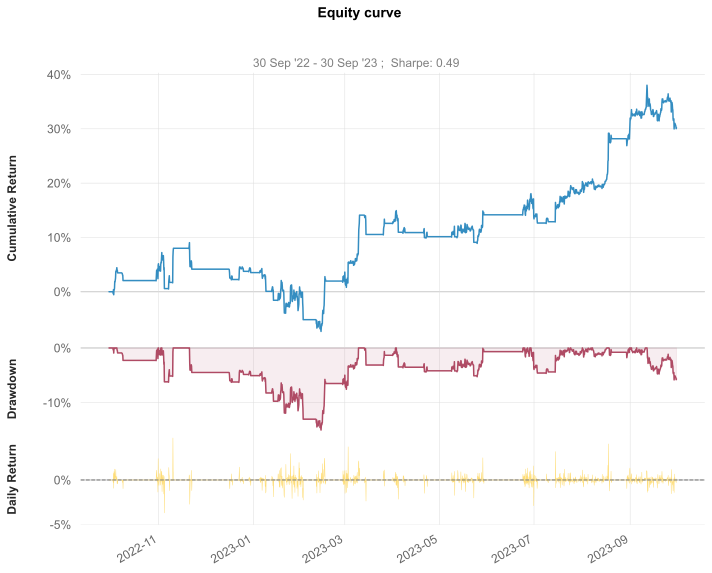

In [34]:
from tradeexecutor.utils.notebook import setup_charting_and_output
setup_charting_and_output()


# Needed to improve the resolution of matplotlib chart used here
%config InlineBackend.figure_format = 'svg'

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset


In [35]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    "Example long & short mean reversion strategy",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=900
)

fig.show()

## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [36]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance



In [37]:
from IPython.core.display_functions import display

summary_by_side = analysis.calculate_all_summary_stats_by_side(state=state, time_bucket=CANDLE_TIME_BUCKET)

display(summary_by_side)

,All,Long,Short
Trading period length,331 days 4 hours,-,-
Return %,30.20%,18.77%,10.35%
Annualised return %,33.29%,20.69%,11.41%
Cash at start,"$50,000.00",-,-
Value at end,"$65,101.05",-,-
Trade volume,"$2,998,431.22","$2,003,806.34","$994,624.87"
Position win percent,35.14%,44.00%,16.67%
Total positions,37,25,12
Won positions,13,11,2
Lost positions,24,14,10


In [38]:
summary = analysis.calculate_summary_statistics(state=state, time_bucket = CANDLE_TIME_BUCKET)

summary.display()

,
Returns,
Annualised return %,33.29%
Lifetime return %,30.20%
Realised PnL,"$14,561.74"
Trade period,331 days 4 hours
,
Holdings,
Total assets,"$65,101.05"
Cash left,"$16,022.08"
Open position value,"$49,078.96"


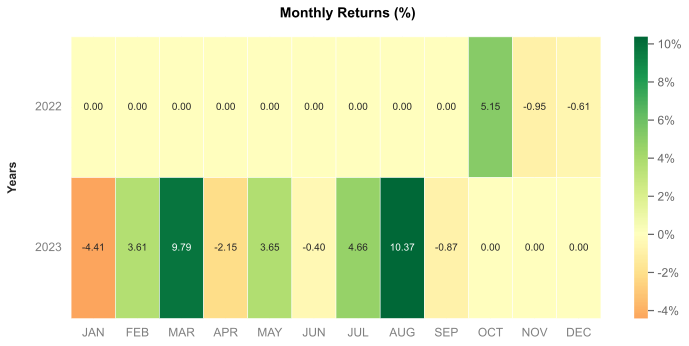

In [39]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

In [40]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

,0
Trading period length,331 days 4 hours
Return %,30.20%
Annualised return %,33.29%
Cash at start,"$50,000.00"
Value at end,"$65,101.05"
Trade volume,"$2,998,431.22"
Position win percent,35.14%
Total positions,37
Won positions,13
Lost positions,24


In [41]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

with pd.option_context("display.max_row", None):
    display(metrics)

,Strategy
Start Period,2022-10-01
End Period,2023-09-30
Risk-Free Rate,0.0%
Time in Market,45.0%
Cumulative Return,30.2%
CAGR﹪,30.3%
Sharpe,0.59
Prob. Sharpe Ratio,92.86%
Smart Sharpe,0.57
Sortino,0.9


### Position and trade timeline

Display all positions and how much profit they made.

In [45]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

expanded_timeline["Real PnL USD"] = expanded_timeline["Port. value at open"].diff().shift(-1)
expanded_timeline["discrepancies"] = expanded_timeline["Real PnL USD"] - expanded_timeline["PnL USD"]

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


Remarks,Type,Opened at,Duration,Exchange,Base asset,Quote asset,Position open value,Position close value,PnL USD,PnL %,Open mid price USD,Close mid price USD,Trade count,LP fees,Port. value at open,Real PnL USD,discrepancies
SL,Long,2022-10-02,11 hours,Uniswap v3,WETH,USDC,"$37,500.00","$37,260.78",-239.223579,-0.64%,"$1,298.602672","$1,290.318502",2,$37.39,50000.000000,-239.223579,-0.000000
SL,Long,2022-10-03,2 days 9 hours,Uniswap v3,WETH,USDC,"$37,320.58","$39,296.77",1976.188551,5.30%,"$1,277.352586","$1,344.990586",2,$38.32,49760.776421,1976.188551,0.000000
SL,Long,2022-10-08,14 hours,Uniswap v3,WETH,USDC,"$38,802.72","$38,091.51",-711.217707,-1.83%,"$1,330.809753","$1,306.417252",2,$38.46,51736.964972,-711.217707,0.000000
SL,Short,2022-10-30,5 days 7 hours,Uniswap v3,WETH,USDC,"$38,269.31","$38,975.30",-699.807530,-1.81%,"$1,629.018090","$1,658.936152",2,$38.63,51025.747265,-738.439585,-38.632056
SL,Long,2022-11-07,14 hours,Uniswap v3,WETH,USDC,"$37,715.48","$38,285.45",569.965868,1.51%,"$1,551.279275","$1,574.722599",2,$38.01,50287.307680,569.965868,0.000000
SL,Long,2022-11-10,10 hours,Uniswap v3,WETH,USDC,"$38,142.96","$41,286.56",3143.606739,8.24%,"$1,101.746930","$1,192.548994",2,$39.73,50857.273548,3143.606739,-0.000000
SL,Long,2022-11-20,10 hours,Uniswap v3,WETH,USDC,"$40,500.66","$39,575.86",-924.798473,-2.28%,"$1,167.884653","$1,141.216990",2,$40.05,54000.880287,-924.798473,-0.000000
SL,Long,2022-11-21,3 hours,Uniswap v3,WETH,USDC,"$39,807.06","$39,046.19",-760.874163,-1.91%,"$1,142.016139","$1,120.187585",2,$39.44,53076.081813,-760.874163,0.000000
SL,Long,2022-11-21,11 hours,Uniswap v3,WETH,USDC,"$39,236.41","$38,997.80",-238.603623,-0.61%,"$1,091.439545","$1,084.802305",2,$39.13,52315.207650,-238.603623,0.000000
SL,Long,2022-12-16,5 hours,Uniswap v3,WETH,USDC,"$39,057.45","$38,238.19",-819.264095,-2.10%,"$1,213.722640","$1,188.263750",2,$38.66,52076.604027,-819.264095,-0.000000


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [43]:
print("All ok")

All ok
